# **Deforum Stable Diffusion on FILM v0.8**

A blending of Deforum and Google FILM (for ultra high quality frame interpolation) to create ultra-smooth deforum videos. 

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). Notebook by [deforum](https://discord.gg/upmXXsrwZc) Google FILM (frame interpolation) integration by [boxabirds](https://github.com/boxabirds)


In [1]:
#@markdown **NVIDIA GPU**
import torch
import subprocess, os, sys

if torch.cuda.is_available():
    sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(f"{sub_p_res[:-1]}")
    has_cuda = True
else:
    print("No Nvidia GPU software or hardware found")

Tesla T4, 15360 MiB, 15098 MiB


# Setup

In [2]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys

def setup_environment():
    start_time = time.time()
    print_subprocess = False
    use_xformers_for_colab = True
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'
    if 'google.colab' in str(ipy):
        print("..setting up environment")

        # weird hack
        #import torch
        
        all_process = [
            ['pip', 'install', 'omegaconf', 'einops==0.4.1', 'pytorch-lightning==1.7.7', 'torchmetrics', 'transformers', 'safetensors', 'kornia'],
            ['git', 'clone', 'https://github.com/boxabirds/deforum-stable-diffusion'],
            ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq','scikit-learn','torchsde','open-clip-torch','numpngw'],
        ]
        for process in all_process:
            running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
            if print_subprocess:
                print(running)
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend([
            'deforum-stable-diffusion/',
            'deforum-stable-diffusion/src',
        ])
        if use_xformers_for_colab:

            print("..installing triton and xformers")

            all_process = [['pip', 'install', 'triton', 'xformers']]
            for process in all_process:
                running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
                if print_subprocess:
                    print(running)
    else:
        sys.path.extend([
            'src'
        ])
    end_time = time.time()
    print(f"..environment set up in {end_time-start_time:.0f} seconds")
    return

setup_environment()


import random
import clip
from IPython import display

from helpers.settings import load_args
from helpers.render import do_render
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.video import frames2vid

..setting up environment
..installing triton and xformers
..environment set up in 48 seconds


In [3]:
#@markdown **Path Setup**
from types import SimpleNamespace
from helpers.save_images import get_output_folder

def Root():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}

    #@markdown **Model Setup**
    map_location = "cuda" #@param ["cpu", "cuda"]
    print( f"map_location: {map_location}" )
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "Protogen_V2.2.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root = Root()
root = SimpleNamespace(**root)

root.models_path, root.output_path = get_model_output_paths(root)

map_location: cuda
Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [4]:
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)

config_path: /content/deforum-stable-diffusion/configs/v1-inference.yaml
ckpt_path: /content/drive/MyDrive/AI/models/Protogen_V2.2.ckpt
..checking sha256
..hash is correct
..loading model


# Settings

In [5]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '2D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 270 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0: (1.22), 1: (1.06), 2: (1.04), 3: (1.18), 4: (1.06), 5: (1.04), 6: (1.16), 7: (1.05), 8: (1.04), 9: (1.17), 10: (1.15), 11: (1.04), 12: (1.18), 13: (1.05), 14: (1.04), 15: (1.14), 16: (1.06), 17: (1.04), 18: (1.15), 19: (1.05), 20: (1.04), 21: (1.16), 22: (1.16), 23: (1.04), 24: (1.18), 25: (1.05), 26: (1.04), 27: (1.15), 28: (1.06), 29: (1.04), 30: (1.18), 31: (1.05), 32: (1.04), 33: (1.16), 34: (1.14), 35: (1.04), 36: (1.19), 37: (1.05), 38: (1.04), 39: (1.18), 40: (1.06), 41: (1.04), 42: (1.20), 43: (1.05), 44: (1.04), 45: (1.15), 46: (1.13), 47: (1.04), 48: (1.16), 49: (1.05), 50: (1.04), 51: (1.18), 52: (1.06), 53: (1.04), 54: (1.20), 55: (1.05), 56: (1.04), 57: (1.15), 58: (1.13), 59: (1.04), 60: (1.19), 61: (1.06), 62: (1.04), 63: (1.17), 64: (1.06), 65: (1.04), 66: (1.18), 67: (1.05), 68: (1.04), 69: (1.15), 70: (1.17), 71: (1.04), 72: (1.14), 73: (1.05), 74: (1.04), 75: (1.19), 76: (1.06), 77: (1.04), 78: (1.21), 79: (1.05), 80: (1.04), 81: (1.16), 82: (1.14), 83: (1.04), 84: (1.15), 85: (1.06), 86: (1.04), 87: (1.19), 88: (1.06), 89: (1.04), 90: (1.20), 91: (1.05), 92: (1.04), 93: (1.15), 94: (1.13), 95: (1.04), 96: (1.22), 97: (1.05), 98: (1.04), 99: (1.21), 100: (1.05), 101: (1.04), 102: (1.20), 103: (1.05), 104: (1.04), 105: (1.14), 106: (1.14), 107: (1.04), 108: (1.18), 109: (1.05), 110: (1.04), 111: (1.17), 112: (1.05), 113: (1.04), 114: (1.23), 115: (1.05), 116: (1.04), 117: (1.19), 118: (1.14), 119: (1.04), 120: (1.17), 121: (1.05), 122: (1.04), 123: (1.17), 124: (1.05), 125: (1.04), 126: (1.19), 127: (1.04), 128: (1.04), 129: (1.17), 130: (1.13), 131: (1.04), 132: (1.16), 133: (1.05), 134: (1.04), 135: (1.17), 136: (1.05), 137: (1.04), 138: (1.20), 139: (1.04), 140: (1.04), 141: (1.14), 142: (1.13), 143: (1.04), 144: (1.20), 145: (1.05), 146: (1.04), 147: (1.16), 148: (1.05), 149: (1.04), 150: (1.19), 151: (1.05), 152: (1.04), 153: (1.14), 154: (1.11), 155: (1.04), 156: (1.19), 157: (1.05), 158: (1.04), 159: (1.19), 160: (1.05), 161: (1.04), 162: (1.16), 163: (1.04), 164: (1.04), 165: (1.15), 166: (1.13), 167: (1.04), 168: (1.04), 169: (1.04), 170: (1.04), 171: (1.04), 172: (1.04), 173: (1.04), 174: (1.54), 175: (1.24), 176: (1.05), 177: (1.43), 178: (1.21), 179: (1.06), 180: (1.37), 181: (1.25), 182: (1.05), 183: (1.85), 184: (2.02), 185: (1.06), 186: (1.55), 187: (1.25), 188: (1.06), 189: (1.44), 190: (1.19), 191: (1.06), 192: (1.51), 193: (1.20), 194: (1.06), 195: (1.50), 196: (1.22), 197: (1.50), 198: (1.49), 199: (1.21), 200: (1.06), 201: (1.44), 202: (1.22), 203: (1.06), 204: (1.47), 205: (1.20), 206: (1.05), 207: (1.75), 208: (1.82), 209: (1.06), 210: (1.52), 211: (1.23), 212: (1.06), 213: (1.52), 214: (1.21), 215: (1.06), 216: (1.46), 217: (1.26), 218: (1.06), 219: (1.47), 220: (1.21), 221: (1.49), 222: (1.45), 223: (1.21), 224: (1.06), 225: (1.52), 226: (1.21), 227: (1.06), 228: (1.43), 229: (1.24), 230: (1.06), 231: (1.83), 232: (1.80), 233: (1.05), 234: (1.55), 235: (1.20), 236: (1.05), 237: (1.41), 238: (1.23), 239: (1.06), 240: (1.42), 241: (1.22), 242: (1.06), 243: (1.50), 244: (1.24), 245: (1.56), 246: (1.50), 247: (1.20), 248: (1.05), 249: (1.42), 250: (1.21), 251: (1.05), 252: (1.39), 253: (1.22), 254: (1.06), 255: (1.74), 256: (2.04), 257: (1.06), 258: (1.45), 259: (1.19), 260: (1.05), 261: (1.48), 262: (1.22), 263: (1.06), 264: (1.46), 265: (1.14), 266: (1.04), 267: (1.12), 268: (1.04), 269: (1.04), 270: (1.04)"#@param {type:"string"}
    translation_x = "0:(0)"#@param {type:"string"}
    translation_y = "0:(3)"#@param {type:"string"}
    translation_z = "0:(0)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(0)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.70)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_video_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_video_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_video_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_video_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_video_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_video_generate_inputframes = False #@param {type:"boolean"}
    hybrid_video_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_video_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_video_flow_method = "Farneback" #@param ['Farneback','DenseRLOF','SF']
    hybrid_video_composite = False #@param {type:"boolean"}
    hybrid_video_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_video_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_video_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_video_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_video_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_video_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [6]:
prompts = [
    "a beautiful lake by Asher Brown Durand, trending on Artstation", # the first prompt I want
    "a beautiful portrait of a woman by Artgerm, trending on Artstation", # the second prompt I want
    #"this prompt I don't want it I commented it out",
    #"a nousr robot, trending on Artstation", # use "nousr robot" with the robot diffusion model (see model_checkpoint setting)
    #"touhou 1girl komeiji_koishi portrait, green hair", # waifu diffusion prompts can use danbooru tag groups (see model_checkpoint)
    #"this prompt has weights if prompt weighting enabled:2 can also do negative:-2", # (see prompt_weighting)
]

# raw_animation_prompts = {
# 0: "People wearing coats by the seaside in winter with dark grey skies",
# 32: "Driving in a car along a motorway with a beach and waves in the distance",
# 64: "Rolling green landscapes set against a grey sky, watercolor",
# 95: "3 adults walking along a wintry pebble beach bracing against strong winds",
# 127: "Close up of 3 adults on a wintry pebble beach looking happy, healthy and revitalised",
# 160: "3 adults walking along a wintry pebble beach stepping over stones",
# 192: "3 adults on wintry pebble beach sitting on a picnic mat that is fluttering in the wind",
# 233: "Office scene with people pretending to be nice to each other",
# 247: "People in office with tables, chairs, and sofas of different colours next to a table with coffee and tea cups",
# 264: "Close-up of two people in an office whispering to each other conspiratorially next to a water cooler",
# 279: "Office team cheering and slapping each other on each other's backs",
# 297: "Miserable people sitting on an underground railway that is falling apart",
# 311: "Sad person in their home holding bills, surrounded by a mountain of other bills",
# 329: "Person thinking philosophically, looking up into the sky",
# 344: "Person thinking philosophically, throwing their hands up into the sky in frustration",
# }
# style_extras = "watercolor, cosy, trending on Artstation" #@param {type:"string"}

raw_animation_prompts = {
0: "People wearing coats by the seaside in winter with dark grey skies ",
24: "A car on a winding coastal road surrounded by rolling green hills and grey skies, with a picnic basket and blanket in the backseat.",
48: "Rolling hills of vibrant green grass and trees contrasted against a cloudy grey sky.",
72: "Windswept figure in a jacket standing on a rocky shoreline, watching the waves crash against the rocks in the distance.",
96: "Rising sun illuminating a winter fog, revealing an untouched landscape and coast.",
120: "Windswept grass with stones on the shoreline, scattered across the landscape, a picnic blanket billowing in the distance and a figure standing in silhouette against a grey sky.",
144: "Two figures standing on a pebbly beach,the blanket wavering in the wind.",
174: "People in an office with cubicles, desks, computers and chairs, smiling faces conversing.",
186: "Rainbow-colored furniture, kitchenette with coffee and tea flowing from dispensers",
198: "Cluster of people huddled around a water cooler, laughing and talking.",
208: "Corporate team-building rallying cry hands together shouting gleefullu",
223: "Crowds of commuters on an underground train with seats and windows covered in patches and repair tape.",
234: "Letterbox of front door overflowing with bills and letters",
247: "Person looking up into the sky in questining anguish",
258: "Person standing on a hilltop, arms outstretched, looking out at a sea of green rolling hills against a stormy grey sky and questioning if this is their life."
}





{0: 'People wearing coats by the seaside in winter with dark grey skies ,  in watercolor, cosy, trending on artstation',
 24: 'A car on a winding coastal road surrounded by rolling green hills and grey skies, with a picnic basket and blanket in the backseat.,  in watercolor, cosy, trending on artstation',
 48: 'Rolling hills of vibrant green grass and trees contrasted against a cloudy grey sky.,  in watercolor, cosy, trending on artstation',
 72: 'Windswept figure in a jacket standing on a rocky shoreline, watching the waves crash against the rocks in the distance.,  in watercolor, cosy, trending on artstation',
 96: 'Rising sun illuminating a winter fog, revealing an untouched landscape and coast.,  in watercolor, cosy, trending on artstation',
 120: 'Windswept grass with stones on the shoreline, scattered across the landscape, a picnic blanket billowing in the distance and a figure standing in silhouette against a grey sky.,  in watercolor, cosy, trending on artstation',
 144: 'Two f

In [7]:

from helpers import render


def DeforumArgs():
    #@markdown **Custom Settings**
    override_settings_with_file = False #@param {type:"boolean"}
    settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
    custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

    #@markdown **Image Settings**
    W = 768 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}
    general_style = " in watercolor, cosy, trending on artstation" #@param {type:"string"}

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 50 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Prompt Settings**
    prompt_weighting = True #@param {type:"boolean"}
    normalize_prompt_weights = True #@param {type:"boolean"}
    log_weighted_subprompts = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    batch_name = "" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)
    print(f"outdir is '{outdir}'")

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.1 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  #@param {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 #@param {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}

    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()



In [8]:
args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

if args.override_settings_with_file:
    load_args(args_dict, anim_args_dict, args.settings_file, args.custom_settings_file, verbose=False)



outdir is '/content/drive/MyDrive/AI/StableDiffusion/230508-2043'


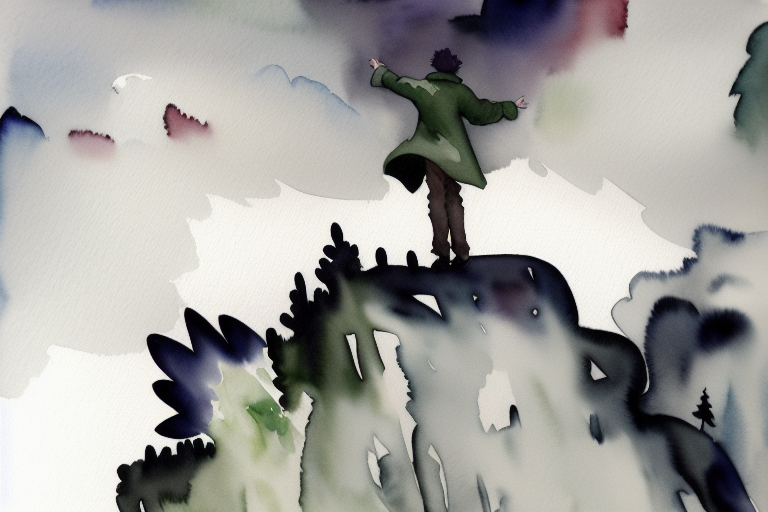

In [10]:
do_render(args, anim_args, root, raw_animation_prompts, general_style)

In [19]:
print(f"saved to output folder '{args.outdir}'")

saved to output folder '/content/drive/MyDrive/AI/StableDiffusion/230508-1945'


# Create Video from frames (Google FILM-based frame interpolation)

[original source](https://www.tensorflow.org/hub/tutorials/tf_hub_film_example)

In [12]:
!pip install mediapy
!sudo apt-get install -y ffmpeg

import tensorflow as tf
import tensorflow_hub as hub

import requests
import numpy as np

from typing import Generator, Iterable, List, Optional
import mediapy as media

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


## Various utility functions as part of the Gooogle-provided demo

In [13]:
_UINT8_MAX_F = float(np.iinfo(np.uint8).max)

def load_image(img_url: str):
  print(f"load_image: {img_url}")
  """Returns an image with shape [height, width, num_channels], with pixels in [0..1] range, and type np.float32."""

  if (img_url.startswith("https")):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image_data = response.content
  else:
    image_data = tf.io.read_file(img_url)
    print(f"image_data for '{img_url}': {image_data}")

  image = tf.io.decode_image(image_data, channels=3)
  image_numpy = tf.cast(image, dtype=tf.float32).numpy()
  return image_numpy / _UINT8_MAX_F


## Interpolator

In [14]:
"""A wrapper class for running a frame interpolation based on the FILM model on TFHub

Usage:
  interpolator = Interpolator()
  result_batch = interpolator(image_batch_0, image_batch_1, batch_dt)
  Where image_batch_1 and image_batch_2 are numpy tensors with TF standard
  (B,H,W,C) layout, batch_dt is the sub-frame time in range [0..1], (B,) layout.
"""


def _pad_to_align(x, align):
  """Pads image batch x so width and height divide by align.

  Args:
    x: Image batch to align.
    align: Number to align to.

  Returns:
    1) An image padded so width % align == 0 and height % align == 0.
    2) A bounding box that can be fed readily to tf.image.crop_to_bounding_box
      to undo the padding.
  """
  # Input checking.
  assert np.ndim(x) == 4
  assert align > 0, 'align must be a positive number.'

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height + height_to_pad,
      'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height,
      'target_width': width
  }
  return padded_x, bbox_to_crop


class Interpolator:
  """A class for generating interpolated frames between two input frames.

  Uses the Film model from TFHub
  """

  def __init__(self, align: int = 64) -> None:
    """Loads a saved model.

    Args:
      align: 'If >1, pad the input size so it divides with this before
        inference.'
    """
    self._model = hub.load("https://tfhub.dev/google/film/1")
    self._align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:
    """Generates an interpolated frame between given two batches of frames.

    All inputs should be np.float32 datatype.

    Args:
      x0: First image batch. Dimensions: (batch_size, height, width, channels)
      x1: Second image batch. Dimensions: (batch_size, height, width, channels)
      dt: Sub-frame time. Range [0,1]. Dimensions: (batch_size,)

    Returns:
      The result with dimensions (batch_size, height, width, channels).
    """
    if self._align is not None:
      x0, bbox_to_crop = _pad_to_align(x0, self._align)
      x1, _ = _pad_to_align(x1, self._align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self._model(inputs, training=False)
    image = result['image']

    if self._align is not None:
      image = tf.image.crop_to_bounding_box(image, **bbox_to_crop)
    return image.numpy()

In [15]:
try: 
  framedir = args.outdir
except NameError: 
  framedir = "/content/drive/MyDrive/AI/StableDiffusion/230508-1945" #@param 

framedir

'/content/drive/MyDrive/AI/StableDiffusion/230508-1945'

In [20]:
#@markdown ##Load up the images from the folder 
#@markdown Take the individual frames from deforum's core flow
#@markdown And load them up. 
#@markdown See https://github.com/google-research/frame-interpolation for docs on how to calculate recursion_times. 
#@markdown See also [deforum+FILM sheet](https://docs.google.com/spreadsheets/d/1njAxk9vsavOQH870x369RJ2v6Ax6spGOpjzLmllRj3A/edit#gid=0) for example calc

times_to_interpolate = 3 #@param {type:"slider", min:1, max:10, step:1}

import glob
filenames = glob.glob(f"{framedir}/*.png")
print(f"filenames: {filenames}")
input_frames = [load_image(image) for image in filenames]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Frame generation

In [17]:
from tqdm import tqdm

def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:
  """Splits halfway to repeatedly generate more frames.

  Args:
    frame1: Input image 1.
    frame2: Input image 2.
    num_recursions: How many times to interpolate the consecutive image pairs.
    interpolator: The frame interpolator instance.

  Yields:
    The interpolated frames, including the first frame (frame1), but excluding
    the final frame2.
  """
  if num_recursions == 0:
    yield frame1
  else:
    # Adds the batch dimension to all inputs before calling the interpolator,
    # and remove it afterwards.
    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:
  """Generates interpolated frames by repeatedly interpolating the midpoint.

  Args:
    frames: List of input frames. Expected shape (H, W, 3). The colors should be
      in the range[0, 1] and in gamma space.
    num_recursions: Number of times to do recursive midpoint
      interpolation.
    interpolator: The frame interpolation model to use.

  Yields:
    The interpolated frames (including the inputs).
  """
  n = len(frames)
  for i in tqdm(range(1, n), desc="Processing frames", unit="frames"):
      yield from _recursive_generator(frames[i - 1], frames[i],
                                      times_to_interpolate, interpolator)
  # Separately yield the final frame.
  yield frames[-1]

## Execution of frame generation

In [21]:
interpolator = Interpolator()
frames = list(
    interpolate_recursively(input_frames, times_to_interpolate,
                                        interpolator))
print(f'video with {len(frames)} frames')

# 24fps is the only native fps of 24, 25, 30, 60, 120 that exactly matches the number of key frames + recursive interpolations
#media.show_video(frames, fps=24, title='FILM interpolated video')


Processing frames: 100%|██████████| 269/269 [17:55<00:00,  4.00s/frames]

video with 2153 frames


In [ ]:
#media.show_video(frames, fps=24, title='FILM interpolated video')

In [22]:
fps = 24
basic_movie_filename =  framedir + " movie " + str(fps) + ".mp4"
media.write_video(basic_movie_filename, frames, fps=fps)

# Create Video From Frames (Deforum only)

In [ ]:
# def BasicArgs():
#     skip_video_for_run_all = True #@param {type: 'boolean'}
#     fps = 3 #@param {type:"number"}
#     #@markdown **Manual Settings**
#     use_manual_settings = False #@param {type:"boolean"}
#     image_path = "/content/drive/MyDrive/AI/StableDiffusion/2023-01/StableFun/20230101212135_%05d.png" #@param {type:"string"}
#     mp4_path = "/content/drive/MyDrive/AI/StableDiffusion/2023-01/StableFun/20230101212135.mp4" #@param {type:"string"}
#     render_steps = False  #@param {type: 'boolean'}
#     path_name_modifier = "x0_pred" #@param ["x0_pred","x"]
#     make_gif = False
#     bitdepth_extension = "exr" if args.bit_depth_output == 32 else "png"
#     skip_disconnect_for_run_all = True #@param {type: 'boolean'}
#     max_frames = "60" #@param {type:"string"}
#     return locals()

In [ ]:

# basics = BasicArgs()
# basics = SimpleNamespace(**basics)

# if basics.skip_video_for_run_all == True:
#     print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
# else:
#     frames2vid(args,anim_args,basics)
# if basics.skip_disconnect_for_run_all == True:
#     print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
# else:
#     from google.colab import runtime
#     runtime.unassign()